In [53]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R
import copy

# Let's write an expanded-ensemble Sampler() class

class EESampler_RigidThreeParticle(object):
    """An expanded-ensemble Sampler class for a rigid-triangle 3-particle/3-restraint system."""
    
    def __init__(self, k_values=[0.0, 0.5, 1.0, 2.0, 5.0, 10., 15., 20., 50., 100., 200., 400., 800.], L=8.0,
                 x0=np.array([[0.,0.,0.],[1.,0.,0.], [2.,1.,0.]]),
                 a1=np.array([[0.,0.,0.],[1.,0.,0.], [2.,1.,0.]])):
        """Initialize the class.
        
        INPUT
        k     -- a np.array() of force constant values (kJ/nm^2)
        L     -- the length of the cubic box (nm), extending from -L/2 to L/2.
        x0    -- the initial positions of the particles (np.array of shape (3,3))
        a1    -- position of the harmonic anchors (np.array of shape (3,3))
        """
        
        self.k_values = np.array(k_values) # kJ/mol/nm^2)
        self.L        = L        # nm
        self.x0       = x0       # np.array with shape (3,3) and units nm
        self.a1       = a1       # "
        
        # Calculate distance between  particles 1 and 2
        self.d0       = self.distance(x0[0,:], x0[1,:])  # the initial distance between p2 - p1, as a reference
        self.d        = copy.copy(self.d0)
        print('self.d', self.d)
        
        # Calculate the altitude (height), c, of triangle where p1-p2 is the base
        ### 1. First calculate the area of the triangle as A = (1/2)||v \cross w||
        p1, p2, p3 = x0[0,:], x0[1,:], x0[2,:] 
        v, w = p2-p1, p3-p1
        area = 0.5*np.linalg.norm( np.cross(v,w) )
        ### 2. Then since A = 1/2 * base * height, the height is c = 2*area/base
        self.c0 = 2.0 * area / np.linalg.norm(v)
        self.c = copy.copy(self.c0)
        print('self.c', self.c)
        
        # calculate e, the projection of p3-p1 = w in the p2-p1 = v direction
        unit_vec_along_p12 = v / self.d
        self.e = np.abs(np.dot(w,unit_vec_along_p12))
        print('self.e', self.e)
        
        self.d3 = np.linalg.norm(w)    # the initial distance between p3 - p1, as a reference
        
        
        self.k_index  = 0        # thermodynamic index

        self.n_ensembles = self.k_values.shape[0]

        self.x        = copy.copy(self.x0)
        self.U        = self.energy(self.x, self.k_values[self.k_index])
        
        
        ### Monte Carlo and Wang-Landau (WL) settings
        self.dx      = 0.2      # Gaussian translation step size  
        self.dtheta  = 0.2      # Gaussian step size for angular (in radians)
        
        self.RT      = 2.479           # in kJ/mol at 298 K
        
        self.all_pbc_shifts = []
        for i in [-L, 0, L]:
            for j in [-L, 0, L]:
                for k in [-L, 0, L]:
                    self.all_pbc_shifts.append([i,j,k])
        self.all_pbc_shifts = np.array(self.all_pbc_shifts)
        # print('self.all_pbc_shifts', self.all_pbc_shifts)
        
        self.wl_increment = 5.0     # in kT
        self.wl_scaling   = 0.5     # (0.5 is a la R. E. Belardinelli, and V. D. Pereyra, JCP 2007), 0.8 is MRS
        self.flatness     = 0.8     # if all histogram values are within flatness*100
                                    # percent of the mean counts, decrease wl_increment and reset histogram
        self.wl_increment_freq  = 10        # frequency to update wl sampling
        self.g = np.zeros(self.n_ensembles) # bias energies
        self.h = np.zeros(self.n_ensembles) # histogram counts
        
        self.use_1_over_t       = False    # switch to updating increment as c_1_over_t/(nsteps) when
        self.c_1_over_t         = 10.0   #     the wl_increment < c_1_over_t/(nsteps)  
                                           #     (a la R. E. Belardinelli, and V. D. Pereyra, JCP 2007)
        self.has_switched_to_1_over_t = False
        self.steps_before_1_over_t = 10000 # wait at least these number of steps before switching to 1/t
        self.print_every        = 10000 
        self.traj_every         = 100 
        
    def theory_dg_in_kT(self, verbose=True):
        """Returns the theoretical value for the 3-restraint potential at all k_values."""
        if verbose:
            print('self.d', self.d)
            print('self.c', self.c)
            print('self.e', self.e)
            print('self.L', self.L)

        kc_coeff = 1.0 + (self.e/self.d)**2.0
        if verbose:
            print('kc_coeff', kc_coeff)
        kp1_coeff = 1.0 + (self.c**2 + self.e**2)/(self.d**2.0)
        if verbose:
            print('kp1_coeff', kp1_coeff)

        '''
        theory_dG_in_kT = -1.0*( 3.0/2.0*np.log(2.0*np.pi*ee.RT/(3.0*ee.k_values[1:]))        \ # translational
                                + 1.0/2.0*np.log(2.0*np.pi*ee.RT/(2.0*ee.k_values[1:]))       \ # rot about d
                                + 1.0/2.0*np.log(2.0*np.pi*ee.RT/(kc_coeff*ee.k_values[1:]))  \ # rot about c
                                + 1.0/2.0*np.log(2.0*np.pi*ee.RT/(kp1_coeff*ee.k_values[1:])) \ # rot out of page
                                - np.log( ee.L**3 * 8.0 * (np.pi**2) * (ee.d)**2 * ee.c  ) )
        '''

        theory_dG_in_kT = -1.0*( 3.0/2.0*np.log(2.0*np.pi*self.RT/(3.0*self.k_values[1:]))        \
                                + 1.0/2.0*np.log(2.0*np.pi*self.RT/(self.k_values[1:]))       \
                                + 1.0/2.0*np.log(2.0*np.pi*self.RT/(kc_coeff*self.k_values[1:]))  \
                                + 1.0/2.0*np.log(2.0*np.pi*self.RT/(kp1_coeff*self.k_values[1:])) \
                                - np.log( self.L**3 * 8.0 * (np.pi**2) * (self.d)**2 * self.c  ) )
        return theory_dG_in_kT
    
    def energy(self, x, k):
        """Returns the energy of the harmonic potential in units kJ/mol, for position x."""
        return 0.5*k* np.sum((x-self.a1)*(x-self.a1))
    
    def distance(self, p1, p2):
        """Return the distance between two particles (np.array of shape (3,))"""
        return np.sqrt( np.dot(p2-p1,p2-p1) ) 
        
    def sample(self, nsteps, verbose=True):
        """Perform WL expanded ensemble sampling with MC position moves."""
        
        # store transition counts
        T_counts = np.zeros( (self.n_ensembles, self.n_ensembles) )
        accepted = 0
        data = []
    
        for step in range(nsteps):

            ########################
            ### MC moves
            
            # Before we do any moves, we need to reassemble the rod if it has
            # disjointed from any periodic box separations.
            p1, p2, p3 = self.x[0,:], self.x[1,:], self.x[2,:]
            
            tol = 1e-3
            # print('p1, p2', p1, p2, 'self.distance(p1, p2)', self.distance(p1, p2), 'self.d', self.d)
            p2_distance_deviation = np.abs(self.distance(p1, p2) - self.d0)
            p3_distance_deviation = np.abs(self.distance(p1, p3) - self.d3)
            if p2_distance_deviation + p3_distance_deviation  > tol:
                # print(step, 'points out of the box.  Reassembling...')          
                ## Find all images of the second and third particles
                all_images_p2 = np.tile(p2, 27).reshape(27, 3) + self.all_pbc_shifts
                all_images_p3 = np.tile(p3, 27).reshape(27, 3) + self.all_pbc_shifts
                ### select the image that is the closest to particle 1  (note: this only works of self.d < L/2)
                p2_displacements = all_images_p2 - np.tile(p1, 27).reshape(27, 3)
                p3_displacements = all_images_p3 - np.tile(p1, 27).reshape(27, 3)
                # print('displacements', displacements)
                p2_sq_distances = np.sum(p2_displacements * p2_displacements, axis=1)
                p3_sq_distances = np.sum(p3_displacements * p3_displacements, axis=1)
                # print('sq_distances', sq_distances)
                p2_closest_index = np.argmin(p2_sq_distances)     
                p2 = all_images_p2[p2_closest_index,:]
                p3_closest_index = np.argmin(p3_sq_distances)     
                p3 = all_images_p3[p3_closest_index,:]
            x_assembled = np.array([list(p1),list(p2),list(p3)])
            # print('step', step, 'x_assembled', x_assembled)
            
            # For debugging, store the distance betwen the poarticles for the reassembled rod
            self.d        = self.distance(x_assembled[0,:], x_assembled[1,:])
            
            # For debugging, store the triangle altitude c
            v, w = p2-p1, p3-p1
            self.c = np.linalg.norm( np.cross(v,w) ) / np.linalg.norm(v)
                
            # propose a MC translation move
            nudge = np.random.randn(3)
            x_new = x_assembled + self.dx*np.tile(nudge, 3).reshape(3,3)
            
            # propose a rotation move
            
            ## get a random vector on the unit sphere
            vec = 2.0*np.random.random(3) - 1.0
            while np.dot(vec,vec) > 1.0:
                vec = 2.0*np.random.random(3) - 1.0
            vec = vec/np.sqrt( np.dot(vec,vec) ) 
            
            ## Find the rotation transformation about this axis
            rotation_radians = self.dtheta*np.random.randn()
            rotation_vector = rotation_radians * vec
            rotation = R.from_rotvec(rotation_vector)
            
            ## Translate the rigid rod to the origin
            midpoint = (x_new[0,:] + x_new[1,:] + x_new[2,:])/3.0
            x_new -= np.tile(midpoint, 3).reshape(3,3)
            ## Rotate it
            x_new_rotated = rotation.apply(x_new)
            # print(x_new_rotated)
            ## Translate it back
            x_new_rotated += np.tile(midpoint, 3).reshape(3,3)
            
            # if any coordinate of x_new goes outside the box, wrap it back in:
            x_new = ((x_new_rotated + np.array([self.L/2., self.L/2., self.L/2.])) % self.L) - np.array([self.L/2., self.L/2., self.L/2.])         
            U_new = self.energy(x_new, self.k_values[self.k_index])
            # print('step', step, 'self.x', 'x_new', self.x, x_new)
            # print('\tself.U', 'U_new', self.U, U_new)
            
            
            # accept MC   move according to the metropolis criterion
            accept = False
            P_accept = min(1., np.exp(-(U_new - self.U)/self.RT))
            if np.random.rand() < P_accept:
                accept = True
            if accept:
                accepted += 1
                self.x = x_new
                self.U = U_new

            ########################
            ### WL moves
            ###  next, update the WL histogams and propose a WL move
                
            if (step%self.wl_increment_freq == 1):

                # WL histograms
                self.g[self.k_index] -= self.wl_increment
                self.h[self.k_index] += 1.0

                # reset the bias to i=0 reference
                self.g -= self.g[0]

                # attempt a move to a neighboring ensemble
                wl_accept = False
                if np.random.rand() < 0.5:
                    k_index_new = self.k_index + 1
                else:
                    k_index_new = self.k_index - 1

                if (k_index_new >= 0) and (k_index_new < self.n_ensembles):
                    energies = self.energy(self.x, self.k_values) 
                    P_wl_accept = min(1., np.exp( -(energies[k_index_new]/self.RT - self.g[k_index_new] - energies[self.k_index]/self.RT + self.g[self.k_index] )))
                    if np.random.rand() < P_wl_accept:                    #print(f'2 - is now {particles[x]}')
                        wl_accept = True    
                if wl_accept:
                    T_counts[self.k_index, k_index_new] += 1.0
                    self.k_index = k_index_new
                else:
                    T_counts[self.k_index,self.k_index] += 1.0


                # check if the histogram is flat enough
                mean_counts = self.h.mean()

                which_are_flat_enough = (self.h > self.flatness*mean_counts)*(self.h < (2.0-self.flatness)*mean_counts)
                if step%self.print_every == 0:
                    print('h', self.h, 'mean_counts', mean_counts)
                    print('which_are_flat_enough', which_are_flat_enough)

                if step >= self.steps_before_1_over_t:
                    if (self.has_switched_to_1_over_t == False) and (self.wl_increment < self.c_1_over_t/float(step)):
                        print('#### Switching to 1/t method ( wl_increment =', self.wl_increment, ') ####')
                        self.has_switched_to_1_over_t = True

                if np.sum( which_are_flat_enough.astype(int) ) == self.n_ensembles:
                    if self.has_switched_to_1_over_t:
                        self.wl_increment = self.c_1_over_t/float(step)
                    else:
                        self.wl_increment *= self.wl_scaling
                    self.h = np.zeros(self.n_ensembles)

            # print a status report
            if step%self.print_every == 0:
                print('step', step, '| λ index', self.k_index, '| wl_increment =', self.wl_increment, 'kT')
                if not verbose: # just post first and last ensemble info
                    print('%8d\t%8d\t%3.4f'%(0, self.h[0], self.g[0]))
                    print('%8d\t%8d\t%3.4f'%(self.n_ensembles, self.h[-1], self.g[-1]))
                if verbose:
                    print('# ensemble\tk_value\thistogram\tg (kT)')
                    for k in range(self.n_ensembles):
                        outstr = '%8d\t%4.1f\t%8d\t%3.4f'%(k, self.k_values[k], self.h[k], self.g[k])
                        if k == self.k_index:
                            outstr += ' <<'
                        print(outstr)
                print()

            # store sample in trajectory
            if step%self.traj_every == 0:
                dhdl = self.energy(self.x, self.k_values) - self.energy(self.x, self.k_index)
                data.append([step, self.k_index,
                             self.x[0,0], self.x[0,1], self.x[0,2],
                             self.x[1,0], self.x[1,1], self.x[1,2],
                             self.x[2,0], self.x[2,1], self.x[2,2],
                             self.d, self.c,
                             self.wl_increment, self.g[-1], dhdl, T_counts])


        trajectory = pd.DataFrame(data, columns=['step', 'lambda',
          'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'distance', 'height',
          'increment','free_energy','dhdl', 'transition_matrix'])
        print(accepted)
        return trajectory


      

In [42]:
ee = EESampler_RigidThreeParticle()


self.d 1.0
self.c 1.0
self.e 2.0


self.d 1.0
self.c 1.0
self.e 2.0
step 0 | λ index 0 | wl_increment = 5.0 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	       0	0.0000 <<
       1	 0.5	       0	0.0000
       2	 1.0	       0	0.0000
       3	 2.0	       0	0.0000
       4	 5.0	       0	0.0000
       5	10.0	       0	0.0000
       6	15.0	       0	0.0000
       7	20.0	       0	0.0000
       8	50.0	       0	0.0000
       9	100.0	       0	0.0000
      10	200.0	       0	0.0000
      11	400.0	       0	0.0000
      12	800.0	       0	0.0000

step 10000 | λ index 11 | wl_increment = 2.5 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	       0	0.0000
       1	 0.5	       0	-5.0000
       2	 1.0	       0	-10.0000
       3	 2.0	       0	-10.0000
       4	 5.0	       0	-10.0000
       5	10.0	       6	0.0000
       6	15.0	       6	0.0000
       7	20.0	       5	2.5000
       8	50.0	      19	2.5000
       9	100.0	      25	7.5000
      10	200.0	      30	10.0000
      11	400.0	      33	7.5000 <<
      12	800.0	      33	12.5000


step 170000 | λ index 12 | wl_increment = 0.3125 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	     203	0.0000
       1	 0.5	     203	3.1250
       2	 1.0	     212	4.6875
       3	 2.0	     232	6.5625
       4	 5.0	     274	9.0625
       5	10.0	     284	12.1875
       6	15.0	     285	13.7500
       7	20.0	     286	15.3125
       8	50.0	     286	18.4375
       9	100.0	     288	19.6875
      10	200.0	     310	20.9375
      11	400.0	     355	22.5000
      12	800.0	     382	25.3125 <<

step 180000 | λ index 7 | wl_increment = 0.15625 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	       0	0.0000
       1	 0.5	       0	2.1875
       2	 1.0	       2	3.7500
       3	 2.0	       5	5.4688
       4	 5.0	       9	7.6562
       5	10.0	      17	10.7812
       6	15.0	      21	12.9688
       7	20.0	      24	13.4375 <<
       8	50.0	      25	20.1562
       9	100.0	      11	28.2812
      10	200.0	       0	33.1250
      11	400.0	       0	38.7500
      12	800.0	       0	41.5625

step 190000 

step 340000 | λ index 8 | wl_increment = 0.009765625 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	      47	0.0000
       1	 0.5	      13	4.5508
       2	 1.0	       5	6.9141
       3	 2.0	       5	8.3984
       4	 5.0	      14	10.5762
       5	10.0	      26	12.6660
       6	15.0	      33	13.9844
       7	20.0	      40	14.7949
       8	50.0	      88	17.9590 <<
       9	100.0	     104	20.3418
      10	200.0	      83	22.7148
      11	400.0	      66	25.1270
      12	800.0	       0	27.0605

step 350000 | λ index 1 | wl_increment = 0.009765625 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	      72	0.0000
       1	 0.5	      31	4.6191 <<
       2	 1.0	      64	6.5820
       3	 2.0	      77	7.9395
       4	 5.0	      66	10.3125
       5	10.0	      95	12.2363
       6	15.0	     104	13.5352
       7	20.0	     110	14.3555
       8	50.0	     190	17.2070
       9	100.0	     198	19.6680
      10	200.0	     182	21.9922
      11	400.0	     196	24.1016
      12	800.0	     139	25.9473

st

step 510000 | λ index 11 | wl_increment = 0.00244140625 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	     433	0.0000
       1	 0.5	     486	3.4302
       2	 1.0	     473	5.0879
       3	 2.0	     502	6.7163
       4	 5.0	     453	9.2188
       5	10.0	     433	11.1768
       6	15.0	     475	12.3926
       7	20.0	     495	13.4375
       8	50.0	     549	16.3965
       9	100.0	     604	18.6743
      10	200.0	     665	21.0791
      11	400.0	     693	23.3838 <<
      12	800.0	     555	25.8398

step 520000 | λ index 10 | wl_increment = 0.00244140625 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	     438	0.0000
       1	 0.5	     520	3.3594
       2	 1.0	     519	4.9878
       3	 2.0	     557	6.5942
       4	 5.0	     492	9.1357
       5	10.0	     478	11.0791
       6	15.0	     510	12.3193
       7	20.0	     540	13.3398
       8	50.0	     586	16.3184
       9	100.0	     664	18.5400
      10	200.0	     762	20.8545 <<
      11	400.0	     875	22.9517
      12	800.0	     875	25.0708

step 680000 | λ index 7 | wl_increment = 0.001220703125 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	     564	0.0000
       1	 0.5	     514	3.8818
       2	 1.0	     523	5.5676
       3	 2.0	     564	7.2241
       4	 5.0	     534	9.7803
       5	10.0	     602	11.8457
       6	15.0	     649	12.9919
       7	20.0	     738	13.9307 <<
       8	50.0	     675	16.9055
       9	100.0	     571	19.2004
      10	200.0	     577	21.4319
      11	400.0	     579	23.6389
      12	800.0	     649	25.9875

step 690000 | λ index 5 | wl_increment = 0.001220703125 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	     564	0.0000
       1	 0.5	     518	3.8770
       2	 1.0	     536	5.5518
       3	 2.0	     606	7.1729
       4	 5.0	     596	9.7046
       5	10.0	     664	11.7700 <<
       6	15.0	     701	12.9285
       7	20.0	     808	13.8452
       8	50.0	     749	16.8152
       9	100.0	     652	19.1016
      10	200.0	     690	21.2939
      11	400.0	     710	23.4790
      12	800.0	     945	25.6262

step 850000 | λ index 3 | wl_increment = 0.001220703125 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	    1332	0.0000
       1	 0.5	    1714	3.3545
       2	 1.0	    1785	4.9646
       3	 2.0	    1770	6.6895 <<
       4	 5.0	    1825	9.1418
       5	10.0	    1939	11.1511
       6	15.0	    1925	12.3718
       7	20.0	    2040	13.2788
       8	50.0	    1902	16.3452
       9	100.0	    1821	18.6121
      10	200.0	    1943	20.7019
      11	400.0	    2175	22.6282
      12	800.0	    2568	24.5825

step 860000 | λ index 9 | wl_increment = 0.001220703125 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	    1482	0.0000
       1	 0.5	    1828	3.3984
       2	 1.0	    1880	5.0317
       3	 2.0	    1856	6.7676
       4	 5.0	    1905	9.2273
       5	10.0	    2013	11.2439
       6	15.0	    2004	12.4585
       7	20.0	    2131	13.3508
       8	50.0	    1995	16.4148
       9	100.0	    1893	18.7073 <<
      10	200.0	    1982	20.8374
      11	400.0	    2195	22.7869
      12	800.0	    2575	24.7571

step 1020000 | λ index 3 | wl_increment = 0.0006103515625 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	    1030	0.0000
       1	 0.5	     822	3.5596
       2	 1.0	     747	5.2362
       3	 2.0	     670	7.0911 <<
       4	 5.0	     675	9.5514
       5	10.0	     774	11.5601
       6	15.0	     820	12.8394
       7	20.0	     827	13.7738
       8	50.0	    1010	16.7944
       9	100.0	     933	19.0472
      10	200.0	    1006	21.1304
      11	400.0	     987	23.1757
      12	800.0	     703	25.3082

step 1030000 | λ index 6 | wl_increment = 0.0006103515625 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	    1066	0.0000
       1	 0.5	     891	3.5394
       2	 1.0	     826	5.2100
       3	 2.0	     734	7.0740
       4	 5.0	     758	9.5227
       5	10.0	     858	11.5308
       6	15.0	     904	12.8101 <<
       7	20.0	     906	13.7476
       8	50.0	    1124	16.7468
       9	100.0	    1046	19.0002
      10	200.0	    1104	21.0925
      11	400.0	    1057	23.1549
      12	800.0	     730	25.

step 1190000 | λ index 5 | wl_increment = 0.00030517578125 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	    1106	0.0000
       1	 0.5	    1034	3.6298
       2	 1.0	    1043	5.2780
       3	 2.0	    1149	7.1140
       4	 5.0	     996	9.6265
       5	10.0	     937	11.6562 <<
       6	15.0	    1007	12.9080
       7	20.0	    1026	13.8403
       8	50.0	     971	16.8399
       9	100.0	     929	19.1342
      10	200.0	     854	21.2488
      11	400.0	     716	23.3179
      12	800.0	     646	25.5194

step 1200000 | λ index 8 | wl_increment = 0.00030517578125 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	    1240	0.0000
       1	 0.5	    1130	3.6414
       2	 1.0	    1122	5.2948
       3	 2.0	    1213	7.1353
       4	 5.0	    1031	9.6567
       5	10.0	     993	11.6800
       6	15.0	    1065	12.9312
       7	20.0	    1083	13.8638
       8	50.0	    1043	16.8588 <<
       9	100.0	    1012	19.1498
      10	200.0	     943	21.2625
      11	400.0	     798	23.3337
      12	800.0	     741	2

step 1360000 | λ index 5 | wl_increment = 0.000152587890625 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	      93	0.0000
       1	 0.5	     267	3.6292
       2	 1.0	     281	5.3070
       3	 2.0	     320	7.1452
       4	 5.0	     292	9.6822
       5	10.0	     254	11.7201 <<
       6	15.0	     243	12.9828
       7	20.0	     299	13.9020
       8	50.0	     248	16.9167
       9	100.0	     238	19.1798
      10	200.0	     206	21.3103
      11	400.0	     213	23.4232
      12	800.0	     308	25.5623

step 1370000 | λ index 8 | wl_increment = 0.000152587890625 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	     124	0.0000
       1	 0.5	     318	3.6261
       2	 1.0	     364	5.2991
       3	 2.0	     411	7.1361
       4	 5.0	     376	9.6741
       5	10.0	     377	11.7061
       6	15.0	     343	12.9723
       7	20.0	     412	13.8895
       8	50.0	     377	16.9017 <<
       9	100.0	     352	19.1672
      10	200.0	     254	21.3077
      11	400.0	     241	23.4236
      12	800.0	     313

step 1530000 | λ index 12 | wl_increment = 7.62939453125e-05 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	      93	0.0000
       1	 0.5	      50	3.6372
       2	 1.0	      43	5.2940
       3	 2.0	      57	7.1475
       4	 5.0	      79	9.7203
       5	10.0	      73	11.7635
       6	15.0	      76	13.0296
       7	20.0	     115	13.9301
       8	50.0	     227	16.9115
       9	100.0	     206	19.1714
      10	200.0	     126	21.3342
      11	400.0	      91	23.4790
      12	800.0	     121	25.6302 <<

step 1540000 | λ index 3 | wl_increment = 7.62939453125e-05 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	      96	0.0000
       1	 0.5	     104	3.6333
       2	 1.0	     126	5.2879
       3	 2.0	     165	7.1395 <<
       4	 5.0	     178	9.7130
       5	10.0	     147	11.7580
       6	15.0	     160	13.0234
       7	20.0	     170	13.9261
       8	50.0	     284	16.9073
       9	100.0	     253	19.1680
      10	200.0	     182	21.3301
      11	400.0	     215	23.4698
      12	800.0	     27

step 1700000 | λ index 8 | wl_increment = 3.814697265625e-05 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	     595	0.0000
       1	 0.5	     619	3.6406
       2	 1.0	     662	5.2941
       3	 2.0	     827	7.1375
       4	 5.0	    1065	9.7010
       5	10.0	    1112	11.7451
       6	15.0	    1053	13.0106
       7	20.0	    1100	13.9122
       8	50.0	     933	16.9011 <<
       9	100.0	     877	19.1647
      10	200.0	     743	21.3273
      11	400.0	     672	23.4661
      12	800.0	     558	25.6269

step 1710000 | λ index 8 | wl_increment = 3.814697265625e-05 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	     597	0.0000
       1	 0.5	     653	3.6394
       2	 1.0	     704	5.2925
       3	 2.0	     873	7.1358
       4	 5.0	    1133	9.6985
       5	10.0	    1196	11.7420
       6	15.0	    1147	13.0070
       7	20.0	    1210	13.9080
       8	50.0	    1063	16.8962 <<
       9	100.0	    1007	19.1598
      10	200.0	     828	21.3241
      11	400.0	     742	23.4636
      12	800.0	     6

step 1870000 | λ index 4 | wl_increment = 3.814697265625e-05 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	    1551	0.0000
       1	 0.5	    1775	3.6330
       2	 1.0	    1868	5.2845
       3	 2.0	    2152	7.1234
       4	 5.0	    2347	9.6886 <<
       5	10.0	    2436	11.7311
       6	15.0	    2485	12.9924
       7	20.0	    2559	13.8930
       8	50.0	    2465	16.8791
       9	100.0	    2481	19.1399
      10	200.0	    2183	21.3088
      11	400.0	    1883	23.4564
      12	800.0	    1631	25.6225

step 1880000 | λ index 2 | wl_increment = 3.814697265625e-05 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	    1645	0.0000
       1	 0.5	    1858	3.6334
       2	 1.0	    1966	5.2844 <<
       3	 2.0	    2304	7.1212
       4	 5.0	    2490	9.6867
       5	10.0	    2556	11.7301
       6	15.0	    2588	12.9921
       7	20.0	    2632	13.8938
       8	50.0	    2537	16.8800
       9	100.0	    2528	19.1417
      10	200.0	    2198	21.3118
      11	400.0	    1883	23.4600
      12	800.0	    16

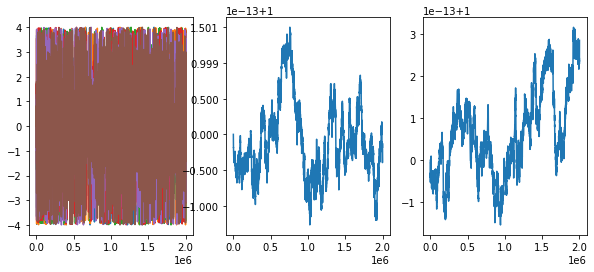

In [47]:
ee = EESampler_RigidThreeParticle()

nsteps = 2000000
traj = ee.sample(nsteps)
# print(traj['dhdl'])

step = traj.loc[:,'step'].values
p1 = np.zeros((step.shape[0], 3))
p1[:,0] = traj.loc[:,'x1'].values
p1[:,1] = traj.loc[:,'y1'].values
p1[:,2] = traj.loc[:,'z1'].values
p2 = np.zeros((step.shape[0], 3))
p2[:,0] = traj.loc[:,'x2'].values
p2[:,1] = traj.loc[:,'y2'].values
p2[:,2] = traj.loc[:,'z2'].values
d = traj.loc[:,'distance'].values
c = traj.loc[:,'height'].values

import matplotlib
from matplotlib import pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(step, p1)
plt.plot(step, p2)
plt.subplot(1,3,2)
plt.plot(step, d)
plt.subplot(1,3,3)
plt.plot(step, c)


self.d 1.0
self.c 1.0
self.e 2.0
self.d 1.0
self.c 1.0
self.e 2.0
self.L 8.0
kc_coeff 5.0
kp1_coeff 6.0
theory_dG_in_kT [ 3.63910456  5.7185461   7.79798765 10.54685984 12.62630138 13.84269671
 14.70574292 17.45461512 19.53405666 21.6134982  23.69293975 25.77238129]
ee.g [ 0.          3.6289978   5.2804184   7.11612701  9.68471527 11.73103333
 12.99034119 13.8904953  16.87911987 19.1463089  21.32175446 23.47545624
 25.64460754]


Text(0, 0.5, '$\\Delta G_{rest}$ (kT)')

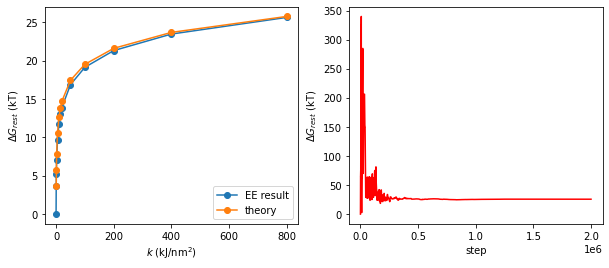

In [55]:
### compare result with experiment

ee_temp = EESampler_RigidThreeParticle()

theory_dG_in_kT = ee_temp.theory_dg_in_kT()
print('theory_dG_in_kT', theory_dG_in_kT)

print('ee.g',ee.g)
plt.figure(figsize=(10,4))

# Plot the final free energy estimates as a function of k
plt.subplot(1,2,1)
plt.plot(ee.k_values, ee.g, 'o-', label='EE result')
plt.plot(ee.k_values[1:], theory_dG_in_kT, 'o-', label='theory')
plt.xlabel('$k$ (kJ/nm$^2$)')
plt.ylabel('$\Delta G_{rest}$ (kT)')
#lt.xscale('log')
plt.legend(loc='best')

# Plot the convergence of the free energy
step = traj.loc[:,'step'].values
free_energy = traj.loc[:,'free_energy'].values
plt.subplot(1,2,2)
plt.plot(step, free_energy, 'r-')
plt.xlabel('step')
plt.ylabel('$\Delta G_{rest}$ (kT)')
# plt.legend(loc='best')




### Let's try parameters from an actual simulation:  REF_RL/RUN0


L0 1.1840481475428983 nm
self.d 0.8326849284092993
self.c 1.0486785581066906
self.e 0.720168877255378
self.d 0.8326849284092993
self.c 1.0486785581066906
self.e 0.720168877255378
self.L 1.1840481475428983
kc_coeff 1.7480098038626308
kp1_coeff 3.334083521100217
theory_dG_in_kT [-2.88375874 -0.80431719  1.27512435  4.02399654  6.10343808  7.31983341
  8.18287963 10.93175182 13.01119336 15.09063491 17.17007645 19.24951799]
ee_REF0.g [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


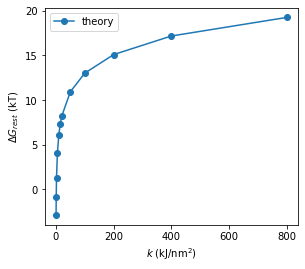

In [49]:
"""
[tud67309@login2 RUN0]$ cat  LIG_res.itp
;LIG_res.itp
[ position_restraints ]
;i funct       fcx        fcy        fcz
6    1        800        800        800
35    1        800        800        800
23    1        800        800        800
"""

# From LIG_h.pdb:
"""
ATOM      6  C28 LIG A   1      11.765 -16.536   1.909  1.00  0.00           C  
...
ATOM     23  C23 LIG A   1      12.358 -10.647   7.766  1.00  0.00           C  
...
ATOM     35  C17 LIG A   1      20.883  -7.674   2.314  1.00  0.00           C  
"""

x0 = np.zeros((3,3))
x0[0,:] = np.array([1.1765, -1.6536, 0.1909])   # converted to nm
x0[1,:] = np.array([1.2358, -1.0647, 0.7766])   # converted to nm
x0[2,:] = np.array([2.0883, -0.7674, 0.2314])   # converted to nm

V0 = 1660.0 # in Å^3 is the standard volume
L0 = ((1660.0)**(1/3)) * 0.1  # converted to nm
print('L0', L0, 'nm')


ee_REF0 = EESampler_RigidThreeParticle(L=L0, x0=x0, a1=x0)

theory_dG_in_kT = ee_REF0.theory_dg_in_kT()
print('theory_dG_in_kT', theory_dG_in_kT)

print('ee_REF0.g', ee_REF0.g)
plt.figure(figsize=(10,4))

# Plot the final free energy estimates as a function of k
plt.subplot(1,2,1)
#plt.plot(ee.k_values, ee.g, 'o-', label='EE result')
plt.plot(ee_REF0.k_values[1:], theory_dG_in_kT, 'o-', label='theory')
plt.xlabel('$k$ (kJ/nm$^2$)')
plt.ylabel('$\Delta G_{rest}$ (kT)')
plt.legend(loc='best')

### REF_RL/RUN1

L0 1.1840481475428983 nm
self.d 0.4836264053998706
self.c 0.834018605392616
ee_REF1.d 0.4836264053998706
ee_REF1.c 0.834018605392616
ee_REF1.L 1.1840481475428983
k_prime_coeff 5.999999999996005
theory_dG_in_kT [-5.57122688 -3.49178533 -1.41234379  1.3365284   3.41596994  4.63236527
  5.49541149  8.24428368 10.32372522 12.40316677 14.48260831 16.56204985]
ee_REF1.g [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


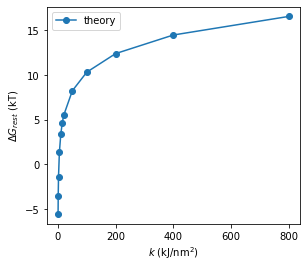

In [26]:
"""
$ cat LIG_res.itp
;LIG_res.itp
[ position_restraints ]
;i funct       fcx        fcy        fcz
11    1        800        800        800
25    1        800        800        800
2     1        800        800        800
"""

# From LIG_h.pdb:
"""
ATOM      2  C12 LIG A   1       6.050   0.774  17.871  1.00  0.00           C  
ATOM     11  C15 LIG A   1       2.770   2.355  21.054  1.00  0.00           C  
ATOM     25  C4  LIG A   1      13.466  -1.210  22.191  1.00  0.00           C  
"""

x0 = np.zeros((3,3))
x0[0,:] = np.array([0.6050, 0.0774, 1.7871])   # converted to nm
x0[1,:] = np.array([0.2770, 0.2355, 2.1054])   # converted to nm
x0[2,:] = np.array([1.3466, -0.1210, 2.2191])   # converted to nm

V0 = 1660.0 # in Å^3 is the standard volume
L0 = ((1660.0)**(1/3)) * 0.1  # converted to nm
print('L0', L0, 'nm')


ee_REF1 = EESampler_RigidThreeParticle(L=L0, x0=x0, a1=x0)

# The *theory* for the triple-restraint rigid rotor says that 
#  dG/kT = -ln ( [(2*\pi)/(\beta *3k )]^{3/2} / L^3
#                [(2*\pi)/(\beta*2k))]^{1/2} * [(2*\pi)/(\beta *(2+c^2/(d/2)^2)k )]^{1/2}  / 4 \pi (d/2)^2
#                [(2*\pi)/(\beta *k )]^{1/2} / 2 \pi c

print('ee_REF1.d', ee_REF1.d)
print('ee_REF1.c', ee_REF1.c)
print('ee_REF1.L', ee_REF1.L)

k_prime_coeff = 2.0 + (ee.c/(ee.d/2.))**2.0
print('k_prime_coeff', k_prime_coeff)

theory_dG_in_kT = -1.0*( 3.0/2.0*np.log(2.0*np.pi*ee_REF1.RT/(3.0*ee_REF1.k_values[1:]))     \
                        + 1.0/2.0*np.log(2.0*np.pi*ee_REF1.RT/(2.0*ee_REF1.k_values[1:])) \
                        + 1.0/2.0*np.log(2.0*np.pi*ee_REF1.RT/(k_prime_coeff*ee_REF0.k_values[1:])) \
                        + 1.0/2.0*np.log(2.0*np.pi*ee_REF1.RT/ee_REF1.k_values[1:])  \
                        - np.log( ee_REF1.L**3 * 8.0 * (np.pi**2) * (ee_REF1.d/2.0)**2 * ee_REF1.c  ) )

print('theory_dG_in_kT', theory_dG_in_kT)

print('ee_REF1.g', ee_REF1.g)
plt.figure(figsize=(10,4))

# Plot the final free energy estimates as a function of k
plt.subplot(1,2,1)
#plt.plot(ee.k_values, ee.g, 'o-', label='EE result')
plt.plot(ee_REF1.k_values[1:], theory_dG_in_kT, 'o-', label='theory')
plt.xlabel('$k$ (kJ/nm$^2$)')
plt.ylabel('$\Delta G_{rest}$ (kT)')
plt.legend(loc='best')

### REF_RL/RUN2

L0 1.1840481475428983 nm
self.d 0.3983634270361678
self.c 0.9244294074859049
ee_REF1.d 0.3983634270361678
ee_REF1.c 0.9244294074859049
ee_REF1.L 1.1840481475428983
k_prime_coeff 5.999999999996005
theory_dG_in_kT [-5.85620189 -3.77676035 -1.69731881  1.05155339  3.13099493  4.34739025
  5.21043647  7.95930867 10.03875021 12.11819175 14.19763329 16.27707483]
ee_REF2.g [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


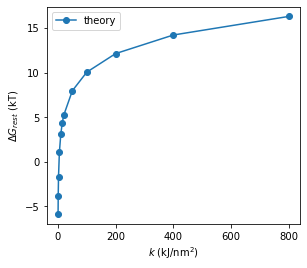

In [27]:
""";LIG_res.itp
[ position_restraints ]
;i funct       fcx        fcy        fcz
13    1        800        800        800
19    1        800        800        800
9    1        800        800        800
"""

# From LIG_h.pdb:
"""
ATOM      9  C2  LIG A   1      12.189   0.731  23.852  1.00  0.00           C  
ATOM     13  CL  LIG A   1      14.006  -1.527  21.119  1.00  0.00          Cl  
ATOM     19  C13 LIG A   1       3.244   2.176  20.610  1.00  0.00           C  
"""

x0 = np.zeros((3,3))
x0[0,:] = 0.1*np.array([12.189, 0.731, 23.852])   # converted to nm
x0[1,:] = 0.1*np.array([14.006, -1.527, 21.119])   # converted to nm
x0[2,:] = 0.1*np.array([ 3.244,  2.176, 20.610])   # converted to nm

V0 = 1660.0 # in Å^3 is the standard volume
L0 = ((1660.0)**(1/3)) * 0.1  # converted to nm
print('L0', L0, 'nm')


ee_REF2 = EESampler_RigidThreeParticle(L=L0, x0=x0, a1=x0)

# The *theory* for the triple-restraint rigid rotor says that 
#  dG/kT = -ln ( [(2*\pi)/(\beta *3k )]^{3/2} / L^3
#                [(2*\pi)/(\beta*2k))]^{1/2} * [(2*\pi)/(\beta *(2+c^2/(d/2)^2)k )]^{1/2}  / 4 \pi (d/2)^2
#                [(2*\pi)/(\beta *k )]^{1/2} / 2 \pi c

print('ee_REF1.d', ee_REF2.d)
print('ee_REF1.c', ee_REF2.c)
print('ee_REF1.L', ee_REF2.L)

k_prime_coeff = 2.0 + (ee.c/(ee.d/2.))**2.0
print('k_prime_coeff', k_prime_coeff)

theory_dG_in_kT = -1.0*( 3.0/2.0*np.log(2.0*np.pi*ee_REF2.RT/(3.0*ee_REF2.k_values[1:]))     \
                        + 1.0/2.0*np.log(2.0*np.pi*ee_REF2.RT/(2.0*ee_REF2.k_values[1:])) \
                        + 1.0/2.0*np.log(2.0*np.pi*ee_REF2.RT/(k_prime_coeff*ee_REF0.k_values[1:])) \
                        + 1.0/2.0*np.log(2.0*np.pi*ee_REF2.RT/ee_REF2.k_values[1:])  \
                        - np.log( ee_REF2.L**3 * 8.0 * (np.pi**2) * (ee_REF2.d/2.0)**2 * ee_REF2.c  ) )

print('theory_dG_in_kT', theory_dG_in_kT)

print('ee_REF2.g', ee_REF2.g)
plt.figure(figsize=(10,4))

# Plot the final free energy estimates as a function of k
plt.subplot(1,2,1)
#plt.plot(ee.k_values, ee.g, 'o-', label='EE result')
plt.plot(ee_REF2.k_values[1:], theory_dG_in_kT, 'o-', label='theory')
plt.xlabel('$k$ (kJ/nm$^2$)')
plt.ylabel('$\Delta G_{rest}$ (kT)')
plt.legend(loc='best')

step 0 | λ index 0 | wl_increment = 5.0 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	       0	0.0000 <<
       1	 0.5	       0	0.0000
       2	 1.0	       0	0.0000
       3	 2.0	       0	0.0000
       4	 5.0	       0	0.0000
       5	10.0	       0	0.0000
       6	15.0	       0	0.0000
       7	20.0	       0	0.0000
       8	50.0	       0	0.0000
       9	100.0	       0	0.0000
      10	200.0	       0	0.0000
      11	400.0	       0	0.0000
      12	800.0	       0	0.0000

step 10000 | λ index 2 | wl_increment = 5.0 kT
# ensemble	k_value	histogram	g (kT)
       0	 0.0	     106	0.0000
       1	 0.5	     106	0.0000
       2	 1.0	     107	-5.0000 <<
       3	 2.0	     107	-5.0000
       4	 5.0	     103	15.0000
       5	10.0	      99	35.0000
       6	15.0	      98	40.0000
       7	20.0	      95	55.0000
       8	50.0	      85	105.0000
       9	100.0	      67	195.0000
      10	200.0	      27	395.0000
      11	400.0	       0	530.0000
      12	800.0	       0	530.0000

step 20000 | λ index 8 | w

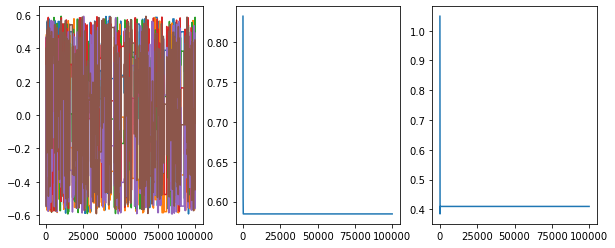

In [14]:
nsteps = 100000
traj = ee.sample(nsteps)
# print(traj['dhdl'])

step = traj.loc[:,'step'].values
p1 = np.zeros((step.shape[0], 3))
p1[:,0] = traj.loc[:,'x1'].values
p1[:,1] = traj.loc[:,'y1'].values
p1[:,2] = traj.loc[:,'z1'].values
p2 = np.zeros((step.shape[0], 3))
p2[:,0] = traj.loc[:,'x2'].values
p2[:,1] = traj.loc[:,'y2'].values
p2[:,2] = traj.loc[:,'z2'].values
d = traj.loc[:,'distance'].values
c = traj.loc[:,'height'].values

import matplotlib
from matplotlib import pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(step, p1)
plt.plot(step, p2)
plt.subplot(1,3,2)
plt.plot(step, d)
plt.subplot(1,3,3)
plt.plot(step, c)

ee.d 0.5844506200868992
ee.c 0.40967777340459033
ee.L 1.1840481475428983
k_prime_coeff 3.965391840602323
theory_dG_in_kT [-6.1104699  -4.03102836 -1.95158682  0.79728538  2.87672692  4.09312225
  4.95616846  7.70504066  9.7844822  11.86392374 13.94336528 16.02280683]
ee.g [   0.    5.    5.   20.   35.   70.   75.   95.  200.  330.  605. 1045.
 1725.]


Text(0, 0.5, '$\\Delta G_{rest}$ (kT)')

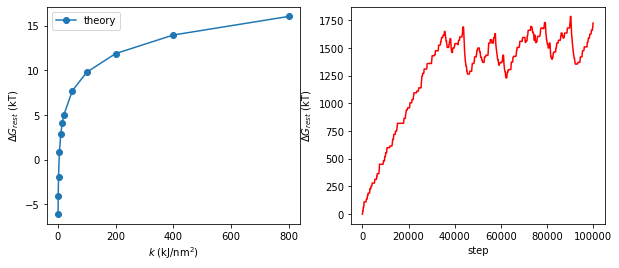

In [16]:
# The *theory* for the triple-restraint rigid rotor says that 
#  dG/kT = -ln ( [(2*\pi)/(\beta *3k )]^{3/2} / L^3
#                [(2*\pi)/(\beta*2k))]^{1/2} * [(2*\pi)/(\beta *(2+c^2/(d/2)^2)k )]^{1/2}  / 4 \pi (d/2)^2
#                [(2*\pi)/(\beta *k )]^{1/2} / 2 \pi c

print('ee.d', ee.d)
print('ee.c', ee.c)
print('ee.L', ee.L)

k_prime_coeff = 2.0 + (ee.c/(ee.d/2.))**2.0
print('k_prime_coeff', k_prime_coeff)

theory_dG_in_kT = -1.0*( 3.0/2.0*np.log(2.0*np.pi*ee.RT/(3.0*ee.k_values[1:]))     \
                        + 1.0/2.0*np.log(2.0*np.pi*ee.RT/(2.0*ee.k_values[1:])) \
                        + 1.0/2.0*np.log(2.0*np.pi*ee.RT/(k_prime_coeff*ee.k_values[1:])) \
                        + 1.0/2.0*np.log(2.0*np.pi*ee.RT/ee.k_values[1:])  \
                        - np.log( ee.L**3 * 8.0 * (np.pi**2) * (ee.d/2.0)**2 * ee.c  ) )

print('theory_dG_in_kT', theory_dG_in_kT)

print('ee.g',ee.g)
plt.figure(figsize=(10,4))

# Plot the final free energy estimates as a function of k
plt.subplot(1,2,1)
#plt.plot(ee.k_values, ee.g, 'o-', label='EE result')
plt.plot(ee.k_values[1:], theory_dG_in_kT, 'o-', label='theory')
plt.xlabel('$k$ (kJ/nm$^2$)')
plt.ylabel('$\Delta G_{rest}$ (kT)')
plt.legend(loc='best')

# Plot the convergence of the free energy
step = traj.loc[:,'step'].values
free_energy = traj.loc[:,'free_energy'].values
plt.subplot(1,2,2)
plt.plot(step, free_energy, 'r-')
plt.xlabel('step')
plt.ylabel('$\Delta G_{rest}$ (kT)')
# plt.legend(loc='best')


